# CNN com JAX/Flax para CIFAR-10

## 1. Imports e paths

In [1]:
import os
import sys
import time
from pathlib import Path
from typing import Dict

import numpy as np
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from flax.training import train_state
from flax import serialization

# Ensure project root is on sys.path so `utils` can be imported
cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    project_root = cwd.parent
elif cwd.name.lower() == "cifar10_project":
    project_root = cwd
elif (cwd / "cifar10_project").is_dir():
    project_root = cwd / "cifar10_project"
else:
    project_root = None

if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from utils.ml_utils import (
    random_cutout,
    ensure_label_indices,
    compute_classification_metrics,
    compute_confusion_matrix,
    build_classification_report,
    log_metrics_to_csv,
    format_duration,
    plot_confusion_matrix_notebook01,
    plot_training_curves_notebook01,
)

print('JAX devices:', jax.devices())
print('JAX default backend:', jax.default_backend())

JAX devices: [CudaDevice(id=0)]
JAX default backend: gpu


In [2]:
PROJECT_ROOT = os.getcwd()
if os.path.basename(PROJECT_ROOT).lower() == 'notebooks':
    PROJECT_ROOT = os.path.dirname(PROJECT_ROOT)
elif os.path.basename(PROJECT_ROOT).lower() != 'cifar10_project':
    candidate = os.path.join(PROJECT_ROOT, 'cifar10_project')
    if os.path.isdir(candidate):
        PROJECT_ROOT = candidate

DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
REPORTS_DIR = os.path.join(PROJECT_ROOT, 'reports')

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

data_path = os.path.join(PROCESSED_DIR, 'cifar10_processed.npz')
performance_report_path = os.path.join(DATA_DIR, 'model_performance_report.csv')
print('Data path:', data_path)
print('Performance report path:', performance_report_path)

Data path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/processed/cifar10_processed.npz
Performance report path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/model_performance_report.csv


## 2. Carregar dados

In [3]:
data = np.load(data_path)

x_train = data['x_train'].astype(np.float32)
y_train = ensure_label_indices(data['y_train']).astype(np.int32)
x_val = data['x_val'].astype(np.float32)
y_val = ensure_label_indices(data['y_val']).astype(np.int32)
x_test = data['x_test'].astype(np.float32)
y_test = ensure_label_indices(data['y_test']).astype(np.int32)

print('Train:', x_train.shape, y_train.shape)
print('Val:  ', x_val.shape, y_val.shape)
print('Test: ', x_test.shape, y_test.shape)

# Garantir formato [0,1] como no pipeline atual
if x_train.max() > 1.0:
    x_train = x_train / 255.0
    x_val = x_val / 255.0
    x_test = x_test / 255.0

Train: (40000, 32, 32, 3) (40000,)
Val:   (10000, 32, 32, 3) (10000,)
Test:  (10000, 32, 32, 3) (10000,)


## 3. Augmentation e batching


In [ ]:
BATCH_SIZE = 64
NUM_CLASSES = 10
SEED = 42

def augment_batch(images: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    out = images.copy()

    # random_flip_left_right
    flip_mask = rng.random(out.shape[0]) < 0.5
    out[flip_mask] = out[flip_mask, :, ::-1, :]

    # random_brightness(max_delta=0.1)
    brightness = rng.uniform(-0.1, 0.1, size=(out.shape[0], 1, 1, 1)).astype(np.float32)
    out = out + brightness

    # random_contrast(lower=0.9, upper=1.1)
    contrast = rng.uniform(0.9, 1.1, size=(out.shape[0], 1, 1, 1)).astype(np.float32)
    mean = out.mean(axis=(1, 2), keepdims=True)
    out = (out - mean) * contrast + mean

    # random cutout
    cutout_mask = rng.random(out.shape[0]) < 0.5
    cutout_indices = np.where(cutout_mask)[0]
    for idx in cutout_indices:
        out[idx] = random_cutout(
            out[idx],
            max_holes=1,
            min_size=4,
            max_size=8,
            fill_value=0.0,
            rng=rng,
        )

    return np.clip(out, 0.0, 1.0)

def iterate_minibatches(
    x: np.ndarray,
    y: np.ndarray,
    batch_size: int,
    shuffle: bool = True,
    augment: bool = False,
    rng: np.random.Generator | None = None,
):
    n = x.shape[0]
    indices = np.arange(n)

    if shuffle:
        (rng or np.random.default_rng()).shuffle(indices)

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_idx = indices[start:end]
        xb = x[batch_idx]
        yb = y[batch_idx]

        if augment:
            xb = augment_batch(xb, rng or np.random.default_rng())

        yield xb.astype(np.float32), yb.astype(np.int32)

## 4. Modelo Flax: Cifar10CNN

In [ ]:
class Cifar10CNN(nn.Module):
    num_classes: int = 10

    @nn.compact
    def __call__(self, x, train: bool = True):
        # Input: 32x32x3

        # Bloco 1: Conv(32) + GeLU, MaxPool
        x = nn.Conv(features=32, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.gelu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding='SAME')
        x = nn.Dropout(rate=0.4)(x, deterministic=not train)

        # Bloco 2: [Conv(64) + BN + GeLU] x2, MaxPool
        for _ in range(2):
            x = nn.Conv(features=64, kernel_size=(3, 3), padding='SAME', use_bias=False)(x)
            x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5)(x)
            x = nn.gelu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding='SAME')
        x = nn.Dropout(rate=0.4)(x, deterministic=not train)

        # Bloco 3: [Conv(128) + BN + GeLU] x2, MaxPool
        for _ in range(2):
            x = nn.Conv(features=128, kernel_size=(3, 3), padding='SAME', use_bias=False)(x)
            x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5)(x)
            x = nn.gelu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding='SAME')
        x = nn.Dropout(rate=0.4)(x, deterministic=not train)

        # Bloco 4: [Conv(256) + BN + GeLU] x2
        for _ in range(2):
            x = nn.Conv(features=256, kernel_size=(3, 3), padding='SAME', use_bias=False)(x)
            x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5)(x)
            x = nn.gelu(x)

        x = nn.Dropout(rate=0.4)(x, deterministic=not train)

        # Global Average Pooling
        x = jnp.mean(x, axis=(1, 2))

        # Dense(10)
        x = nn.Dense(self.num_classes)(x)
        return x

## 5. TrainState, create_train_state, train_step, eval_step

In [6]:
class TrainState(train_state.TrainState):
    batch_stats: Dict

def create_train_state(rng, learning_rate, weight_decay: float = 1e-4):
    model = Cifar10CNN(num_classes=NUM_CLASSES)
    variables = model.init(rng, jnp.ones((1, 32, 32, 3), dtype=jnp.float32), train=True)
    params = variables['params']
    batch_stats = variables['batch_stats']

    tx = optax.adamw(learning_rate=learning_rate, weight_decay=weight_decay)

    return TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=tx,
        batch_stats=batch_stats,
    )

@jax.jit
def train_step(state: TrainState, images: jnp.ndarray, labels: jnp.ndarray, dropout_rng):
    def loss_fn(params):
        logits, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            images,
            train=True,
            mutable=['batch_stats'],
            rngs={'dropout': dropout_rng},
        )
        loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=labels).mean()
        return loss, (logits, updates)

    (loss, (logits, updates)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates['batch_stats'])

    acc = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
    metrics = {'loss': loss, 'accuracy': acc}
    return state, metrics

@jax.jit
def eval_step(state: TrainState, images: jnp.ndarray, labels: jnp.ndarray):
    logits = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        images,
        train=False,
        mutable=False,
    )
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=labels).mean()
    acc = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
    metrics = {'loss': loss, 'accuracy': acc}
    return metrics, logits

## 6. Loop de treino simples (com early stopping)

In [7]:
def run_epoch(
    state,
    x,
    y,
    batch_size,
    train: bool,
    rng: np.random.Generator,
    jax_rng,
    lr_schedule,
):
    losses = []
    accs = []

    for xb, yb in iterate_minibatches(x, y, batch_size=batch_size, shuffle=train, augment=train, rng=rng):
        xb_j = jnp.asarray(xb)
        yb_j = jnp.asarray(yb)

        if train:
            jax_rng, dropout_rng = jax.random.split(jax_rng)
            state, metrics = train_step(state, xb_j, yb_j, dropout_rng)
        else:
            metrics, _ = eval_step(state, xb_j, yb_j)

        losses.append(float(metrics['loss']))
        accs.append(float(metrics['accuracy']))

    current_lr = float(lr_schedule(int(state.step)))
    return state, float(np.mean(losses)), float(np.mean(accs)), jax_rng, current_lr

rng = np.random.default_rng(SEED)
jax_rng = jax.random.PRNGKey(SEED)

learning_rate = 1e-3
weight_decay = 5e-4
epochs = 200
patience = 32

steps_per_epoch = int(np.ceil(len(x_train) / BATCH_SIZE))
decay_steps = max(1, steps_per_epoch * epochs)
lr_schedule = optax.cosine_decay_schedule(
    init_value=learning_rate,
    decay_steps=decay_steps,
    alpha=0.05,
)

state = create_train_state(jax_rng, learning_rate=lr_schedule, weight_decay=weight_decay)

history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'learning_rate': [],
}

best_val_acc = 0.0
best_epoch = 0
best_snapshot = serialization.to_bytes({'params': state.params, 'batch_stats': state.batch_stats})

start_time = time.time()

for epoch in range(1, epochs + 1):
    state, train_loss, train_acc, jax_rng, current_lr = run_epoch(
        state, x_train, y_train, BATCH_SIZE, train=True, rng=rng, jax_rng=jax_rng, lr_schedule=lr_schedule
    )
    state, val_loss, val_acc, jax_rng, _ = run_epoch(
        state, x_val, y_val, BATCH_SIZE, train=False, rng=rng, jax_rng=jax_rng, lr_schedule=lr_schedule
    )

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['learning_rate'].append(current_lr)

    improved = val_acc > best_val_acc
    if improved:
        best_val_acc = val_acc
        best_epoch = epoch
        best_snapshot = serialization.to_bytes({'params': state.params, 'batch_stats': state.batch_stats})

    print(
        f"Epoch {epoch:03d}/{epochs} | "
        f"loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} | "
        f"lr={current_lr:.6f}"
    )

    if (epoch - best_epoch) >= patience:
        print(f"Early stopping at epoch {epoch} (best epoch: {best_epoch}).")
        break

train_time_sec = time.time() - start_time
print(f"Training time: {format_duration(train_time_sec)} ({train_time_sec:.2f} sec)")

best_variables = serialization.from_bytes(
    {'params': state.params, 'batch_stats': state.batch_stats},
    best_snapshot,
)
state = state.replace(params=best_variables['params'], batch_stats=best_variables['batch_stats'])
print(f"Restored best validation checkpoint from epoch {best_epoch}.")

Epoch 001/200 | loss=1.5385 acc=0.4341 | val_loss=1.2124 val_acc=0.5536 | lr=0.001000
Epoch 002/200 | loss=1.1921 acc=0.5732 | val_loss=1.0109 val_acc=0.6378 | lr=0.001000
Epoch 003/200 | loss=1.0518 acc=0.6228 | val_loss=0.8895 val_acc=0.6885 | lr=0.000999
Epoch 004/200 | loss=0.9493 acc=0.6637 | val_loss=0.8028 val_acc=0.7164 | lr=0.000999
Epoch 005/200 | loss=0.8730 acc=0.6911 | val_loss=0.7458 val_acc=0.7362 | lr=0.000999
Epoch 006/200 | loss=0.8147 acc=0.7119 | val_loss=0.7867 val_acc=0.7258 | lr=0.000998
Epoch 007/200 | loss=0.7717 acc=0.7305 | val_loss=0.6646 val_acc=0.7676 | lr=0.000997
Epoch 008/200 | loss=0.7385 acc=0.7396 | val_loss=0.6333 val_acc=0.7816 | lr=0.000996
Epoch 009/200 | loss=0.6972 acc=0.7568 | val_loss=0.6295 val_acc=0.7789 | lr=0.000995
Epoch 010/200 | loss=0.6733 acc=0.7646 | val_loss=0.5696 val_acc=0.8024 | lr=0.000994
Epoch 011/200 | loss=0.6447 acc=0.7735 | val_loss=0.5486 val_acc=0.8102 | lr=0.000993
Epoch 012/200 | loss=0.6219 acc=0.7806 | val_loss=0.55

## 7. Avaliação no teste, CSV e modelo

In [8]:
def predict_dataset(state: TrainState, x: np.ndarray, y: np.ndarray, batch_size: int):
    all_preds = []
    losses = []
    accs = []

    for xb, yb in iterate_minibatches(x, y, batch_size=batch_size, shuffle=False, augment=False):
        metrics, logits = eval_step(state, jnp.asarray(xb), jnp.asarray(yb))
        losses.append(float(metrics['loss']))
        accs.append(float(metrics['accuracy']))
        all_preds.append(np.asarray(jnp.argmax(logits, axis=-1)))

    return np.concatenate(all_preds), float(np.mean(losses)), float(np.mean(accs))

y_pred, test_loss, test_acc = predict_dataset(state, x_test, y_test, BATCH_SIZE)
print(f"JAX/Flax test accuracy: {test_acc:.4f}")
print(f"JAX/Flax test loss: {test_loss:.4f}")

cls_metrics = compute_classification_metrics(y_test, y_pred, average='macro')

row = {
    'model_name': 'CNN - JAX/Flax',
    'num_params': int(sum(np.prod(np.array(p.shape)) for p in jax.tree_util.tree_leaves(state.params))),
    'train_time_sec': round(float(train_time_sec), 2),
    'train_time': format_duration(train_time_sec),
    'timestamp': time.strftime('%Y-%m-%d %H:%M'),
    'accuracy': float(cls_metrics['accuracy']),
    'precision': float(cls_metrics['precision']),
    'recall': float(cls_metrics['recall']),
    'f1': float(cls_metrics['f1']),
    'support': int(cls_metrics['support']),
    'final_accuracy': float(history['accuracy'][-1]),
    'final_loss': float(history['loss'][-1]),
    'final_val_accuracy': float(history['val_accuracy'][-1]),
    'final_val_loss': float(history['val_loss'][-1]),
    'final_learning_rate': float(history['learning_rate'][-1]),
    'epochs_trained': int(len(history['accuracy'])),
    'test_loss': float(test_loss),
}

log_metrics_to_csv(performance_report_path, row, append=True)
print('Logged metrics:', row)

model_path = os.path.join(MODELS_DIR, 'cifar10_cnn_jax_flax.msgpack')
with open(model_path, 'wb') as f:
    f.write(serialization.to_bytes({'params': state.params, 'batch_stats': state.batch_stats}))
print('Saved JAX/Flax model to:', model_path)

JAX/Flax test accuracy: 0.8745
JAX/Flax test loss: 0.5009
Logged metrics: {'model_name': 'CNN - JAX/Flax', 'num_params': 1166474, 'train_time_sec': 781.4, 'train_time': '13 min 01 sec', 'timestamp': '2026-02-19 04:01', 'accuracy': 0.8742, 'precision': 0.8731783290713414, 'recall': 0.8742000000000001, 'f1': 0.873521880988109, 'support': 10000, 'final_accuracy': 0.969725, 'final_loss': 0.08617995829135179, 'final_val_accuracy': 0.8820660828025477, 'final_val_loss': 0.4838552812861789, 'final_learning_rate': 5.052731648902409e-05, 'epochs_trained': 197, 'test_loss': 0.5009206028738219}
Saved JAX/Flax model to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/cifar10_cnn_jax_flax.msgpack


## 8. Relatório e gráficos (padrão do projeto)

Classification Report (JAX/Flax):
              precision    recall  f1-score   support

    airplane     0.8814    0.8990    0.8901      1000
  automobile     0.9335    0.9400    0.9367      1000
        bird     0.8456    0.8270    0.8362      1000
         cat     0.7709    0.7200    0.7446      1000
        deer     0.8587    0.8570    0.8579      1000
         dog     0.8063    0.7990    0.8026      1000
        frog     0.8985    0.9210    0.9096      1000
       horse     0.9178    0.9160    0.9169      1000
        ship     0.9263    0.9300    0.9281      1000
       truck     0.8928    0.9330    0.9125      1000

    accuracy                         0.8742     10000
   macro avg     0.8732    0.8742    0.8735     10000
weighted avg     0.8732    0.8742    0.8735     10000



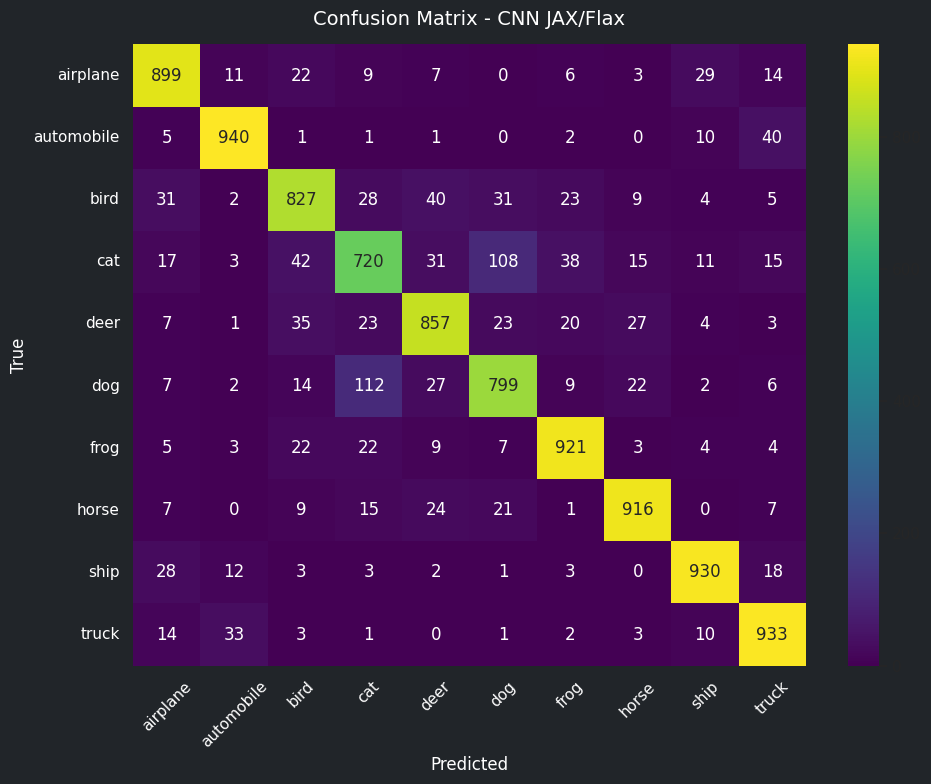

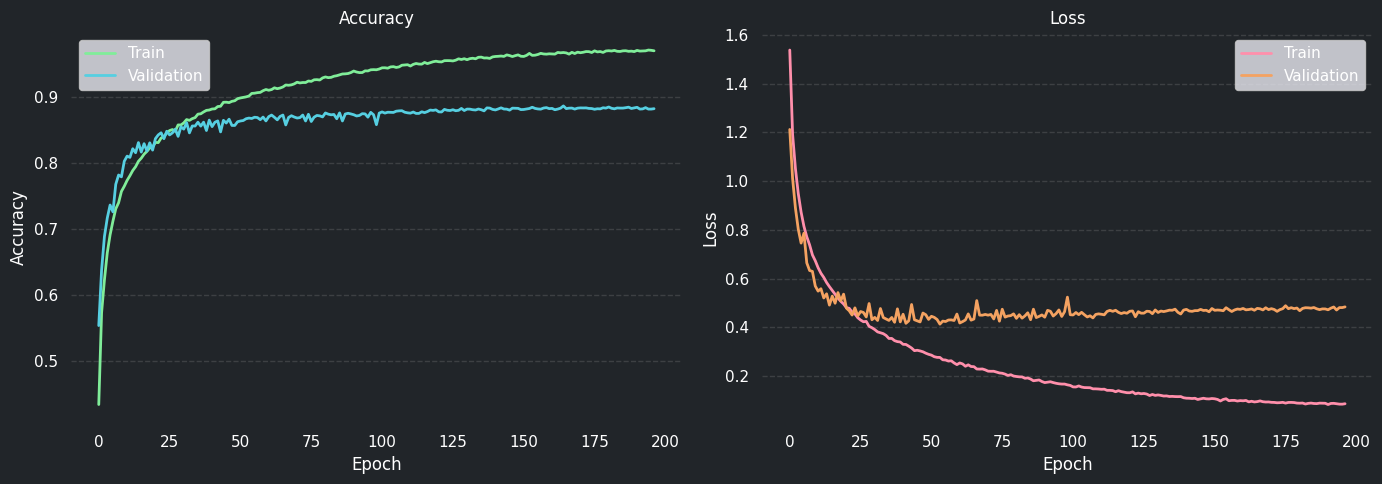

Saved plots to reports/: jax_flax_confusion.png, jax_flax_curves.png


In [9]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print('Classification Report (JAX/Flax):')
print(build_classification_report(y_test, y_pred, target_names=class_names))

cm = compute_confusion_matrix(y_test, y_pred)
plot_confusion_matrix_notebook01(
    confusion=cm,
    class_names=class_names,
    title='Confusion Matrix - CNN JAX/Flax',
    save_path=os.path.join(REPORTS_DIR, 'jax_flax_confusion.png'),
)

plot_training_curves_notebook01(
    history=history,
    save_path=os.path.join(REPORTS_DIR, 'jax_flax_curves.png'),
)

print('Saved plots to reports/: jax_flax_confusion.png, jax_flax_curves.png')